In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
amzn = yf.download('AMZN', '2000-01-01', '2020-01-01')
amzn


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,4.075000,4.478125,3.952344,4.468750,4.468750,322352000
2000-01-04,4.268750,4.575000,4.087500,4.096875,4.096875,349748000
2000-01-05,3.525000,3.756250,3.400000,3.487500,3.487500,769148000
2000-01-06,3.565625,3.634375,3.200000,3.278125,3.278125,375040000
2000-01-07,3.350000,3.525000,3.309375,3.478125,3.478125,210108000
...,...,...,...,...,...,...
2019-12-24,89.690498,89.778503,89.378998,89.460503,89.460503,17626000
2019-12-26,90.050499,93.523003,89.974998,93.438499,93.438499,120108000
2019-12-27,94.146004,95.070000,93.300499,93.489998,93.489998,123732000


In [3]:
def SMA(array, period):
    return array.rolling(period).mean()

In [4]:
sma50 = SMA(amzn['Close'], 20)
sma200 = SMA(amzn['Close'], 200)

In [5]:
def crossover(array1, array2):
    return array1 > array2

def crossunder(array1, array2):
    return array1 < array2

In [6]:
enter_rules = crossover(sma50, sma200)
exit_rules = crossunder(sma50, sma200)

In [7]:
exit_rules

Date
2000-01-03    False
2000-01-04    False
2000-01-05    False
2000-01-06    False
2000-01-07    False
              ...  
2019-12-24     True
2019-12-26     True
2019-12-27     True
2019-12-30     True
2019-12-31     True
Name: Close, Length: 5031, dtype: bool

In [8]:
enter_rules

Date
2000-01-03    False
2000-01-04    False
2000-01-05    False
2000-01-06    False
2000-01-07    False
              ...  
2019-12-24    False
2019-12-26    False
2019-12-27    False
2019-12-30    False
2019-12-31    False
Name: Close, Length: 5031, dtype: bool

In [9]:
check = enter_rules[exit_rules.index == '2000-10-31']
print(check)

Date
2000-10-31    False
Name: Close, dtype: bool


In [10]:
def marketposition_generator(dataset, enter_rules, exit_rules):

    dataset['enter_rules'] = enter_rules
    dataset['exit_rules'] = exit_rules

    status = 0
    mp = []
    for (i, j) in zip(enter_rules, exit_rules):
        if status == 0:
            if i == 1 and j != -1:
                status = 1
        else:
            if j == -1:
                status = 0
        mp.append(status)

    dataset['mp'] = mp
    dataset['mp'] = dataset['mp'].shift(1)
    dataset.iloc[0,2] = 0

    return dataset['mp']

In [11]:
COSTS = 0.50
INSTRUMENT = 1
OPERATION_MONEY = 10000
DIRECTION = "long"
ORDER_TYPE = "market"
ENTER_LEVEL = amzn['Open']

In [12]:
RISK_PER_TRADE = 0.05  # 5% risk per trade
STOP_LOSS_PERCENT = 0.05 # 5% stop loss

def apply_trading_system_with_risk(dataset, direction, order_type, enter_level, enter_rules, exit_rules):
    dataset['enter_rules'] = enter_rules.apply(lambda x: 1 if x else 0)
    dataset['exit_rules'] = exit_rules.apply(lambda x: -1 if x else 0)
    dataset['mp'] = marketposition_generator(dataset, dataset['enter_rules'], dataset['exit_rules'])
    
    if order_type == "market":
        dataset['entry_price'] = np.where(
            (dataset.mp.shift(1) == 0) & (dataset.mp == 1),
            enter_level,
            np.nan
        )
        
    if INSTRUMENT == 1:
        risk_per_trade = OPERATION_MONEY * RISK_PER_TRADE
        stop_loss_amount = enter_level * STOP_LOSS_PERCENT
        
        dataset['number_of_stocks'] = np.where(
            (dataset.mp.shift(1) == 0) & (dataset.mp == 1) & (stop_loss_amount <= enter_level),
            risk_per_trade / stop_loss_amount,
            np.nan
        )
        dataset['number_of_stocks'] = dataset['number_of_stocks'].apply(
            lambda x: round(x, 0)
        ).fillna(method='ffill')
    
    dataset['entry_price'] = dataset['entry_price'].fillna(method='ffill')
    
    if INSTRUMENT == 1:
        dataset['number_of_stocks'] = dataset['number_of_stocks'].fillna(method='ffill')
    
    dataset['events_in'] = np.where((dataset.mp == 1) & (dataset.mp.shift(1) == 0), 'entry', '')
    
    if direction == 'long':
        if INSTRUMENT == 1:
            dataset['open_operations'] = (
                (dataset.Close - dataset.entry_price) * dataset.number_of_stocks
            )
            dataset['open_operations'] = np.where(
                (dataset.mp == 1) & (dataset.mp.shift(-1) == 0),
                (
                    (dataset.Open.shift(-1) - dataset.entry_price) * dataset.number_of_stocks - 2 * COSTS
                ),
                dataset.open_operations
            )
    else:
        if INSTRUMENT == 1:
            dataset['open_operations'] = (
                (dataset.entry_price - dataset.Close) * dataset.number_of_stocks
            )
            dataset['open_operations'] = np.where(
                (dataset.mp == 1) & (dataset.mp.shift(-1) == 0),
                (
                    (dataset.entry_price - dataset.Open.shift(-1)) * dataset.number_of_stocks - 2 * COSTS
                ),
                dataset.open_operations
            )
    
    dataset['open_operations'] = np.where(dataset.mp == 1, dataset.open_operations, 0)
    
    dataset['events_out'] = np.where((dataset.mp == 1) & (dataset.exit_rules == -1), 'exit', '')
    
    dataset['operations'] = np.where(
        (dataset.exit_rules == -1) & (dataset.mp == 1),
        dataset.open_operations,
        np.nan
    )
    
    dataset['closed_equity'] = dataset.operations.fillna(0).cumsum()
    dataset['open_equity'] = dataset.closed_equity + dataset.open_operations - dataset.operations.fillna(0)
    
    dataset.to_csv('trading_system_export.csv')
    
    return dataset

trading_system_with_risk = apply_trading_system_with_risk(amzn, DIRECTION, ORDER_TYPE, ENTER_LEVEL, enter_rules, exit_rules)

net_profit_with_risk = trading_system_with_risk['closed_equity'][-1] - OPERATION_MONEY
print(round(net_profit_with_risk, 2))


50330.7


In [39]:
trading_system_with_risk['daily_returns'] = trading_system_with_risk['closed_equity'].pct_change()
trading_system_with_risk.dropna(subset=['daily_returns'], inplace=True)
strategy_returns=pd.DataFrame(trading_system_with_risk['daily_returns'])

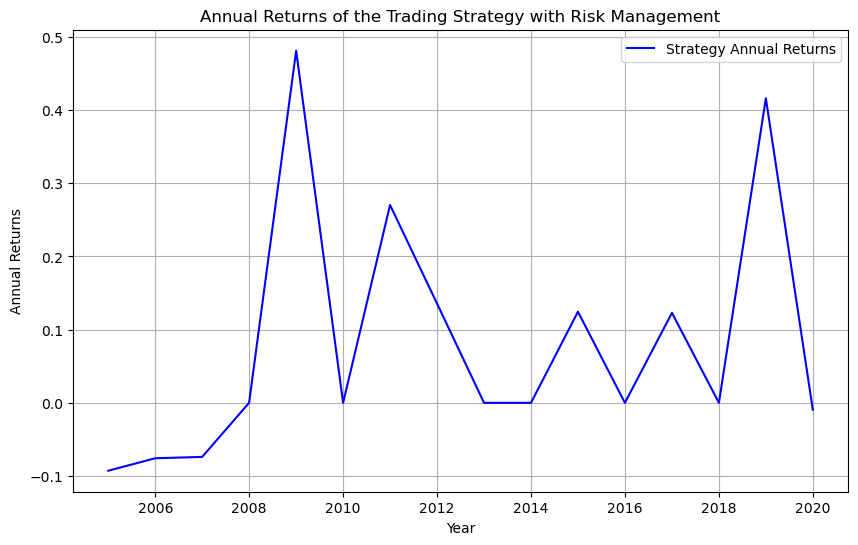

In [54]:
# Resample daily returns to annual returns
annual_returns = strategy_returns['daily_returns'].resample('Y').sum()

# Plotting the annual returns
plt.figure(figsize=(10, 6))
plt.plot(annual_returns.index, annual_returns, label='Strategy Annual Returns', color='blue')
plt.xlabel('Year')
plt.ylabel('Annual Returns')
plt.title('Annual Returns of the Trading Strategy with Risk Management')
plt.legend()
plt.grid(True)
plt.show()





Performance Metrics:

In [41]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Define the functions that we need

#Mean, Volatality and Sharpe Ratio
def performanceMetrics(returns,annualization=252, quantile=.05):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * annualization
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)
    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()
    return metrics

#VaR, CVaR, Max Drawdown
def tailMetrics(returns, quantile=.05, relative=False, mdd=True):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Skewness'] = returns.skew()
    metrics['Kurtosis'] = returns.kurtosis()

    VaR = returns.quantile(quantile)
    CVaR = (returns[returns < returns.quantile(quantile)]).mean()

    if relative:
        VaR = (VaR - returns.mean())/returns.std()
        CVaR = (CVaR - returns.mean())/returns.std()

    metrics[f'VaR ({quantile})'] = VaR
    metrics[f'CVaR ({quantile})'] = CVaR

    if mdd:
        mdd_stats = maximumDrawdown(returns)
        metrics = metrics.join(mdd_stats)

        if relative:
            metrics['Max Drawdown'] = (metrics['Max Drawdown'] - returns.mean())/returns.std()

    return metrics

def maximumDrawdown(returns):
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max

    max_drawdown = drawdown.min()
    end_date = drawdown.idxmin()
    summary = pd.DataFrame({'Max Drawdown': max_drawdown, 'Bottom': end_date})

    for col in drawdown:
        summary.loc[col,'Peak'] = (rolling_max.loc[:end_date[col],col]).idxmax()
        recovery = (drawdown.loc[end_date[col]:,col])
        try:
            summary.loc[col,'Recover'] = pd.to_datetime(recovery[recovery >= 0].index[0])
        except:
            summary.loc[col,'Recover'] = pd.to_datetime(None)

        summary['Peak'] = pd.to_datetime(summary['Peak'])
        try:
            summary['Duration (to Recover)'] = (summary['Recover'] - summary['Peak'])
        except:
            summary['Duration (to Recover)'] = None

        summary = summary[['Max Drawdown','Peak','Bottom','Recover','Duration (to Recover)']]

    return summary

 

 # summary statistics (annualize these statistics):

(a) mean

(b) volatility

(c) Sharpe ratio

# statistics related to tail- risk

(a) Skewness

(b) Excess Kurtosis (in excess of 3)

(c) VaR (.05) - the fifth quantile of historic returns

(d) CVaR (.05) - the mean of the returns at or below the fifth quantile

(e) Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.



In [42]:
performance_metrics = performanceMetrics(strategy_returns)
print("Performance Metrics:")
print(performance_metrics)

Performance Metrics:
               Mean   Vol  Sharpe    Min   Max
daily_returns 0.082 0.201   0.410 -0.093 0.561


In [50]:
tail_metrics = tailMetrics(strategy_returns)
print("Tail Metrics:")
print(tail_metrics)

Tail Metrics:
               Skewness  Kurtosis  VaR (0.05)  CVaR (0.05)  Max Drawdown  \
daily_returns    33.853  1328.571       0.000       -0.066        -0.223   

                    Peak     Bottom    Recover Duration (to Recover)  
daily_returns 2004-03-09 2006-02-15 2008-02-05             1428 days  
